In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import KFold, StratifiedKFold
from lightgbm import LGBMClassifier
import gc
import seaborn as sns

In [2]:
df = pd.read_pickle("./data/non_standard_explore_data.pkl")

In [3]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score
from sklearn.model_selection import train_test_split
seed = 20

# Try just using a train/test split at first without sorting the values by time (I don't know how truly time-based this model will be)
X_train, X_test, y_train, y_test = train_test_split(df.drop('is_bad',axis=1), df['is_bad'], test_size=0.10, random_state=seed)

In [4]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [5]:
# You need to try and balance the classes within the training set
from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state=seed)
x_train_r, y_train_r = sm.fit_resample(X_train, y_train)

In [6]:
def print_score(clf, X_train, y_train, X_test, y_test, train=True):
    if train:
        print("Train Result:\n")
        print("accuracy score: {0:.4f}\n".format(accuracy_score(y_train, clf.predict(X_train))))
        print("Classification Report: \n {}\n".format(classification_report(y_train, clf.predict(X_train))))
        print("Confusion Matrix: \n {}\n".format(confusion_matrix(y_train, clf.predict(X_train))))

        res = cross_val_score(clf, X_train, y_train, cv=10, scoring='auc')
        print("Average Accuracy: \t {0:.4f}".format(np.mean(res)))
        print("Accuracy SD: \t\t {0:.4f}".format(np.std(res)))
        
    elif train==False:
        print("Test Result:\n")        
        print("accuracy score: {0:.4f}\n".format(accuracy_score(y_test, clf.predict(X_test))))
        print("Classification Report: \n {}\n".format(classification_report(y_test, clf.predict(X_test))))
        print("Confusion Matrix: \n {}\n".format(confusion_matrix(y_test, clf.predict(X_test))))    

In [7]:
def kfold_lightgbm(train_df, num_folds, stratified = False, target='TARGET'):
    print("Starting LightGBM. Train shape: {}".format(train_df.shape))
    
    # Cross validation model
    if stratified:
        folds = StratifiedKFold(n_splits= num_folds, shuffle=True, random_state=47)
    else:
        folds = KFold(n_splits= num_folds, shuffle=True, random_state=47)

    oof_preds = np.zeros(train_df.shape[0])

    feature_importance_df = pd.DataFrame()
    feats = [f for f in train_df.columns if f not in [target]]
    
    # Splitting the training set into folds for Cross Validation
    for n_fold, (train_idx, valid_idx) in enumerate(folds.split(train_df[feats], train_df[target])):
        train_x, train_y = train_df[feats].iloc[train_idx], train_df[target].iloc[train_idx]
        valid_x, valid_y = train_df[feats].iloc[valid_idx], train_df[target].iloc[valid_idx]

        # LightGBM parameters found by Bayesian optimization
        clf = LGBMClassifier(
            nthread=4,
            n_estimators=1000,
            learning_rate=0.1,
            num_leaves=32,
            )

        # Fitting the model and evaluating by AUC
        clf.fit(train_x, train_y, eval_set=[(train_x, train_y), (valid_x, valid_y)], 
            eval_metric= 'auc', verbose= 1000, early_stopping_rounds= 200)
        print_score(clf, train_x, train_y, valid_x, valid_y, train=False)
        # Dataframe holding the different features and their importance
        fold_importance_df = pd.DataFrame()
        fold_importance_df["feature"] = feats
        fold_importance_df["importance"] = clf.feature_importances_
        fold_importance_df["fold"] = n_fold + 1
        feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
        
        # Freeing up memory
        del clf, train_x, train_y, valid_x, valid_y
        gc.collect()

    display_importances(feature_importance_df)
    return feature_importance_df

In [8]:
def display_importances(feature_importance_df_):
    cols = feature_importance_df_[["feature", "importance"]].groupby("feature").mean().sort_values(by="importance", ascending=False)[:10].index
    best_features = feature_importance_df_.loc[feature_importance_df_.feature.isin(cols)]
    plt.figure(figsize=(15, 12))
    sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False))
    plt.title('LightGBM Features (avg over folds)')
    plt.tight_layout()
    plt.savefig('lgbm_importances.png')

Starting LightGBM. Train shape: (10000, 108)
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[56]	training's auc: 0.947352	training's binary_logloss: 0.241914	valid_1's auc: 0.709245	valid_1's binary_logloss: 0.325913
Test Result:

accuracy score: 0.8900

Classification Report: 
               precision    recall  f1-score   support

           0       0.89      1.00      0.94       877
           1       0.81      0.14      0.24       123

    accuracy                           0.89      1000
   macro avg       0.85      0.57      0.59      1000
weighted avg       0.88      0.89      0.85      1000


Confusion Matrix: 
 [[873   4]
 [106  17]]

Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[19]	training's auc: 0.852665	training's binary_logloss: 0.303179	valid_1's auc: 0.682489	valid_1's binary_logloss: 0.332743
Test Result:

accuracy score: 0.8890

Classification Report: 
              

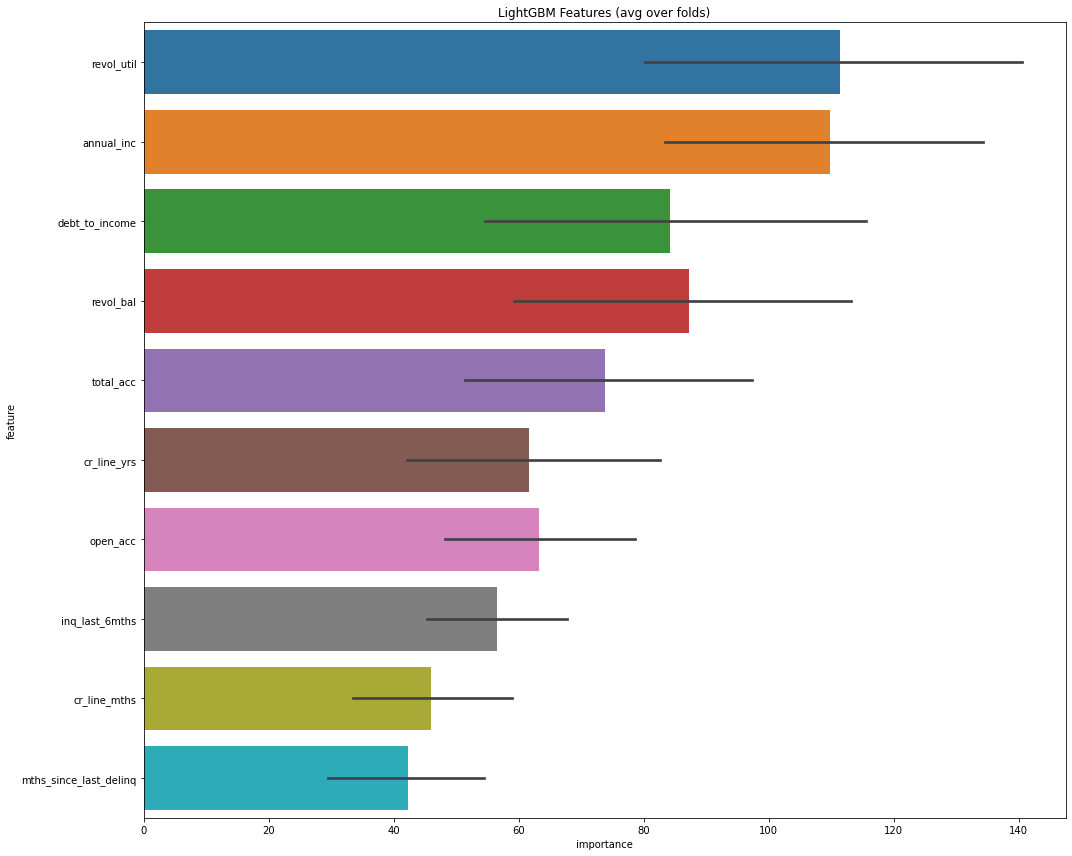

In [9]:
feat_importance = kfold_lightgbm(df, num_folds= 10, stratified= False, target='is_bad')